# Import Packages

In [1]:
import sys, os, pdb, glob
import numpy as np
from astropy.table import Table, join
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
from astropy import constants as const
import matplotlib.ticker
import matplotlib.patches as patches
import matplotlib as mpl

# Define Functions

In [2]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t

# Code

Load in Sigma Orionis data. Separations based on calc_sep_ob.ipynb and dust masses based on calc_dust_masses.ipynb

In [3]:
T = get_data("J/AJ/153/240")
TS = Table.read('../output/sep_OB.txt', format='ascii.ipac')
T = join(T, TS, keys='__HHM2007_')

Load Riglioco+11 M_ACC data & join tables

In [4]:
TR = get_data("J/A+A/525/A47")
TR['Name'].name = '__HHM2007_'
T = join(T, TR, keys='__HHM2007_', join_type='left')

Need to plot in order for this table to match figure in paper

In [5]:
sort_arr = []
for i, val in enumerate(np.arange(1,10)):
   sort_arr += [x for x in T['__HHM2007_'] if str(x)[0] == str(val)] 
TT = Table([np.array(sort_arr)], names=['__HHM2007_'])

Flag dust (non-)detections

Note: Used 2.9 because online table decimal places cutoff to make < 3.0

In [6]:
T['Det'] = T['F1.33'] / T['e_F1.33'] >= 2.9

Get gas detections

In [7]:
GD = np.array(T[(T['F12CO']/T['e_F12CO'] >= 3.0) & (T['l_F12CO'] != '<')]['__HHM2007_'])

Setup and create plot

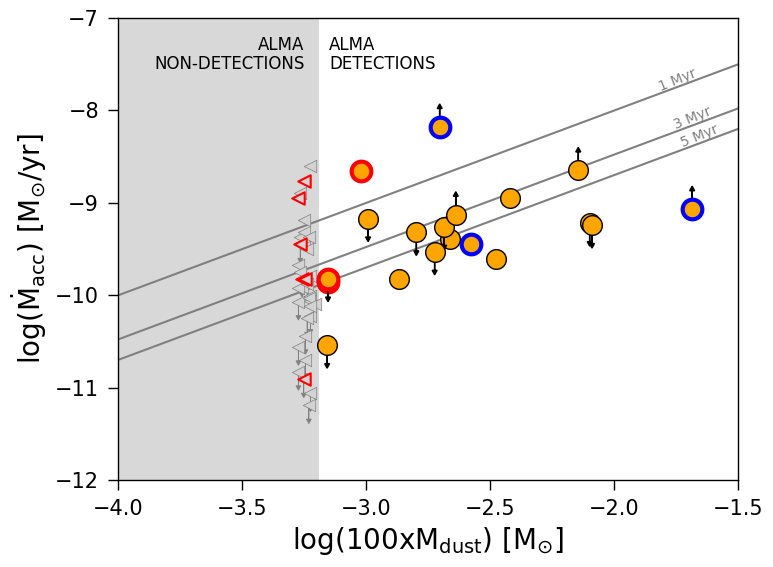

In [8]:
plt.close('all')
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)
mpl.rc('xtick.major', size=7, pad=7, width=1)
mpl.rc('ytick.major', size=7, pad=7, width=1)
mpl.rc('axes', linewidth=1)
mpl.rc('lines', markersize=5)
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)  
ax.set_ylabel(r'$\mathregular{log(\dot{M}_{acc})}$' + ' ' + r'$\mathregular{[M_{\odot}/yr]}$', fontsize=20)
ax.set_xlabel(r'$\mathregular{log(100xM_{dust})}$' + ' ' + r'$\mathregular{[M_{\odot}]}$', fontsize=20)
ax.set_xlim([-4.0, -1.5])
ax.set_ylim([-12, -7])

### PLOT ANNOTATIONS
ax.text(-3.15,-7.35,'ALMA',size=12,ha='left')
ax.text(-3.15,-7.55,'DETECTIONS',size=12,ha='left')
ax.text(-3.25,-7.35,'ALMA',size=12,ha='right')
ax.text(-3.25,-7.55,'NON-DETECTIONS',size=12,ha='right')
ax.add_patch(patches.Rectangle((-5, -13), 1.81, 10, facecolor='gray', alpha=0.3))

### PLOT RATIO LIMITS
xfit  = np.arange(-5, 0, 0.5)
ax.plot(xfit, np.log10((10**xfit)/(1e6)), color='gray', linestyle='solid', zorder=1)
ax.text(-1.83, -7.79, '1 Myr', rotation=22, size=10, color='gray')
ax.plot(xfit, np.log10((10**xfit)/(5e6)), color='gray', linestyle='solid', zorder=1)
ax.text(-1.74, -8.40, '5 Myr', rotation=22, size=10, color='gray')
ax.plot(xfit, np.log10((10**xfit)/(3e6)), color='gray', linestyle='solid', zorder=1)
ax.text(-1.77, -8.20, '3 Myr', rotation=22, size=10, color='gray')

### PLOT SOURCES
for i, val in enumerate(TT['__HHM2007_']):

   ### FIND SOURCE    
   ind = np.where(T['__HHM2007_'] == val)

   ### SKIP IF UNKNONW M_ACC
   if T['logMacc'].mask[ind]:
       continue

   ### PLOT NON-DET
   if ~T['Det'][ind]:

      ### CALCULATE UPPER LIMIT DISK MASS IN SOLAR MASSES
      x = np.log10(3 * 100 * T['e_Mdust'][ind][0] * (const.M_earth.cgs / const.M_sun.cgs).value)
      y = T['logMacc'][ind][0]

      ### MARKER SETTINGS IF GAS DET OR CLOSE TO OB
      EdgeColor, LineWidth, ZOrder = 'gray', 0.5, 2
      if float(T['R_pc'][ind]) < 0.5: EdgeColor, LineWidth, ZOrder = 'red', 1.5, 5
      if val in GD: EdgeColor, LineWidth, ZOrder = 'blue', 1.5, 10
         
      ### PLOT SOURCES
      ax.scatter(x, y, marker='<', facecolor='lightgray', s=80, edgecolor=EdgeColor, linewidth=LineWidth, zorder=ZOrder)
      if (T['l_logMacc'][ind] == '>'):
         ax.arrow(x, y, 0, +0.15, head_width=0.02, head_length=0.05, fc='gray', ec='gray', linewidth=0.5, zorder=1)
      elif (T['l_logMacc'][ind] == '<'):
         ax.arrow(x, y, 0, -0.15, head_width=0.02, head_length=0.05, fc='gray', ec='gray', linewidth=0.5, zorder=1)      


   ### PLOT DETECTED SOURCES
   if T['Det'][ind]:

      ### CALCULATE UPPER LIMIT DISK MASS IN SOLAR MASSES
      x = np.log10(100 * T['Mdust'][ind][0] * (const.M_earth.cgs / const.M_sun.cgs).value)
      y = T['logMacc'][ind][0]
      
      ### MARKER SETTINGS IF GAS DET OR CLOSE TO OB
      EdgeColor, LineWidth, ZOrder = 'black', 1.0, 8
      if val in GD: EdgeColor, LineWidth, ZOrder = 'blue', 3.0, 10
      if float(T['R_pc'][ind]) <= 0.5: EdgeColor, LineWidth, ZOrder = 'red', 3.0, 9

      ### PLOT SOURCES
      if (T['l_logMacc'][ind] == '>'):
         ax.arrow(x, y, 0, +0.2, head_width=0.02, head_length=0.05, fc='black', ec='black', linewidth=1, zorder=7)
      elif (T['l_logMacc'][ind] == '<'):
         ax.arrow(x, y, 0, -0.2, head_width=0.02, head_length=0.05, fc='black', ec='black', linewidth=1, zorder=7)
      else:
         ZOrder=6      
      ax.scatter(x, y, marker='o', facecolor='orange', s=200, edgecolor=EdgeColor, linewidth=LineWidth, zorder=ZOrder)

Save figure

In [9]:
fig.savefig('../output/figure_09.png',bbox_inches='tight',dpi=100)
plt.close('all')